In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("data/data.csv")
df = df.rename(columns={"Scanner_type": "Type"})
df = df.rename(columns={"Study": "Site"})
df["Site"].value_counts()

UKBB              245
PD_MCI_CALGARY    121
HAMBURG           113
BIOCOG             94
SALD               78
C-BIG              76
PD_MCI_PLS         62
Japan_dataset      45
Neurocon           42
Taowu              37
Name: Site, dtype: int64

In [3]:
def drop_study(df, sites):
    mask = ~df["Site"].str.contains("|".join(sites), case=True, na=False)
    df = df[mask]
    df.reset_index(drop=True, inplace=True)
    return df


df = drop_study(df, ["SALD"])

In [4]:
def categorize(df, col):
    type_unique = df[col].unique()
    type_categories = {k: v for k, v in zip(type_unique, np.arange(len(type_unique)))}
    print(type_categories)
    df[col] = df[col].map(type_categories)
    return df, type_categories


def binarize(df, col, val):
    df[col] = (df[col] == val).astype("int")
    return df


df, scanner_dict = categorize(df, "Type")
df, study_dict = categorize(df, "Site")
df = binarize(df, "Group", "PD")

{'GE Discovery 750': 0, 'Siemens Skyra': 1, 'Siemens Prisma_fit': 2, 'Siemens Avanto': 3, 'Siemens Verio': 4, 'Siemens Trio Tim': 5, 'Siemens Trio': 6, 'Siemens Sonata': 7}
{'PD_MCI_CALGARY': 0, 'UKBB': 1, 'HAMBURG': 2, 'C-BIG': 3, 'Neurocon': 4, 'Japan_dataset': 5, 'PD_MCI_PLS': 6, 'Taowu': 7, 'BIOCOG': 8}


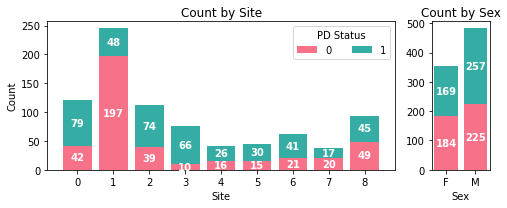

In [5]:
from utils.visualize import view_by_site_sex

view_by_site_sex(df, ["Site", "Sex"])
df = binarize(df, "Sex", "M")

In [6]:
df["strat_column"] = (
    df["Site"].astype("str")
    + "_"
    + df["Sex"].astype("str")
    + "_"
    + df["Group"].astype("str")
)

strata_counts = df["strat_column"].value_counts()
strata_to_drop = strata_counts[strata_counts < 3].index
print(strata_to_drop)
df = df[~df["strat_column"].isin(strata_to_drop)]

Index(['3_1_0'], dtype='object')


In [7]:
from sklearn.model_selection import train_test_split


def stratified_data_split(
    df, target_column, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42
):
    train_val, test = train_test_split(
        df, test_size=test_size, stratify=df[target_column], random_state=random_state
    )
    train, val = train_test_split(
        train_val,
        test_size=val_size / (train_size + val_size),
        stratify=train_val[target_column],
        random_state=random_state,
    )
    return train, val, test


train, val, test = stratified_data_split(df, "strat_column")

In [8]:
train.to_csv("data/train.csv", index=False)
test.to_csv("data/test.csv", index=False)
val.to_csv("data/val.csv", index=False)

In [9]:
import os

import nibabel as nib
import torch
from tqdm import tqdm


def prepare(csv_path, img_dir, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    df = pd.read_csv(csv_path, low_memory=True)

    for i in tqdm(range(len(df))):
        file_name = str(df.iloc[i]["Subject"]) + ".nii.gz"
        img_name = os.path.join(img_dir, os.path.basename(file_name))
        img = nib.load(img_name).get_fdata().astype("f4")

        PD = torch.tensor(df.iloc[i]["Group"])
        sex = torch.tensor(df.iloc[i]["Sex"])
        age = torch.tensor(df.iloc[i]["Age"])
        study = torch.tensor(df.iloc[i]["Site"])
        scanner_type = torch.tensor(df.iloc[i]["Type"])

        img = torch.tensor(np.expand_dims(img, 0))
        torch.save(
            (img, PD, age, sex, study, scanner_type), os.path.join(save_dir, f"{i}")
        )


img_dir = "data/images"

prepare("data/train.csv", img_dir, "data/train")
prepare("data/val.csv", img_dir, "data/val")
prepare("data/test.csv", img_dir, "data/test")

100%|██████████| 84/84 [00:05<00:00, 14.44it/s]
